# PlainTree files names

In [1]:
#PLAINTREE FILES NAMES
directory='E:\\gsi-backup\machine learning\plainTrees_xi\data_for_cutOnLambdaInvMass_5sigma\\'
signalFileName = directory + 'PlainTree_xi_cutLambdaInvMass5_signal5M.root'
backgroundFileName = directory + 'PlainTree_xi_cutLambdaInvMass5_background1M.root'

# Importing the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sn
#from hipe4ml.tree_handler import TreeHandler
#from hipe4ml import plot_utils
from matplotlib.patches import ConnectionPatch
from scipy.stats import binned_statistic as b_s
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from sklearn import datasets, linear_model
import gc
import os

In [3]:
#Shahid's library for importing roottrees
#%%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

C:\Users\Małgorzata\Desktop\JupyterNotebook\CBM_ML_Lambda_Library


fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.


Already up to date.


From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD


running install
running bdist_egg
running egg_info
writing CBM_ML.egg-info\PKG-INFO
writing dependency_links to CBM_ML.egg-info\dependency_links.txt
writing top-level names to CBM_ML.egg-info\top_level.txt
reading manifest file 'CBM_ML.egg-info\SOURCES.txt'
writing manifest file 'CBM_ML.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\KFPF_lambda_cuts.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\plot_tools.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\root_functions.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\tree_importer.py -> build\bdist.win-amd64\egg\CBM_ML
copying build\lib\CBM_ML\__init__.py -> build\bdist.win-amd64\egg\CBM_ML
byte-compiling build\bdist.win-amd64\egg\CBM_ML\KFPF_lambda_cuts.py to KFPF_lambda_cuts.cpython-38.pyc
byte-compiling build\bdist.win-amd

zip_safe flag not set; analyzing archive contents...


# Cuts for mass selection
First cuts to reduce amount of imported data. We choose only signal from +/-5 sigma region around the peak and background around signal.

In [4]:
#CUTS FOR MASS SELECTION
# +/-5 sigma region from the peak for signal
lowerCutSign = 1.2746
upperCutSign = 1.3688
#mean invariant mass
invMass = 1.3217
# cut region for background
lowerCutBckgr = 1.0
upperCutBckgr = 2.0

In [5]:
# We import three root files into our jupyter notebook
#sign - before cleaning but after 5sigma seletion, signal - cleaned
#so that we dont have to reimport everything with each change
sign = tree_importer.tree_importer(signalFileName,'plain_tree',7)

# We only select Xi- candidates in the 5 sigma region around the Xi- invariant mass peak
#we preserve the cleaned dataframe with a changed name
sign = sign[(sign['Complex_generation']==1) & (sign['Complex_pid']==3312) & (sign['Complex_mass']>lowerCutSign) & (sign['Complex_mass']<upperCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the lambda peak
bckgr = tree_importer.tree_importer(backgroundFileName,'plain_tree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = bckgr[(bckgr['Complex_generation'] < 1)
                 & (bckgr['Complex_pid']==3312)
                 & ((bckgr['Complex_mass'] > lowerCutBckgr)
                 & (bckgr['Complex_mass'] < lowerCutSign) | (bckgr['Complex_mass']>upperCutSign) 
                    & (bckgr['Complex_mass'] < upperCutBckgr))]

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2892

In [6]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Complex_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Complex_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['lambdachi2geo','lambdachi2primfirst','lambdachi2primsecond', 'lambdachi2topo','lambdacosinefirst', 'lambdacosinesecond', 'lambdacosinetopo', 'lambdadistance', 'lambdal', 'lambdaloverdl', 'lambdamassbeforeconstraint','lambdapx', 'lambdapy', 'lambdapz', 'geantprocessid', 'generation', 'lambdageantprocessid', 'lambdageneration', 'pid'])
bckgr = bckgr.drop(columns=['lambdachi2geo','lambdachi2primfirst','lambdachi2primsecond', 'lambdachi2topo','lambdacosinefirst', 'lambdacosinesecond', 'lambdacosinetopo', 'lambdadistance', 'lambdal', 'lambdaloverdl', 'lambdamassbeforeconstraint','lambdapx', 'lambdapy', 'lambdapz', 'geantprocessid', 'generation', 'lambdageantprocessid', 'lambdageneration', 'pid'])
#let's check the name prefixes 
sign.iloc[0:1,:]

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,loverdl,mass,p,pT,phi,px,py,pz,rapidity
0,0.18067,16657.328125,269.413086,0.301693,0.99983,0.999983,0.999978,0.027072,2.148147,25.875088,30.004978,1.317334,5.463093,1.257957,1.485262,0.107468,1.253358,5.316289,1.792402


In [7]:
#lets set data labels in latex format
print(sign.columns)
names=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
       '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA', '$\eta$', 
       '$l$', '$\dfrac{l}{\Delta l}$', 'invariant mass', '$p$', '$pT$', '$\phi$', 
       '$p_x$', '$p_y$', '$p_z$', 'rapidity', '$x$', '$y$', '$z$']
#xlabels with unit
xNames=['$\chi^2_{geo}$', '$\chi^2_{prim first}$','$\chi^2_{prim second}$','$\chi^2_{topo}$', 
        '$cosine_{first}$', '$cosine_{second}$',  '$cosine_{topo}$', 'DCA (cm)', 
        '$\eta$', '$l$ (cm)', '$\dfrac{l}{\Delta l}$', 'invariant mass (GeV/$c^2$)', '$p (GeV/c)$', 
        '$pT$ $(GeV/c)$', '$\phi$ $(rad)$', '$p_x$ $(GeV/c)$', '$p_y$ $(GeV/c)$', '$p_z$ $(GeV/c)$', 
        'rapidity', '$x$ $(cm)$', '$y$ $(cm)$', '$z$ $(cm)$']

Index(['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl', 'mass',
       'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity'],
      dtype='object')


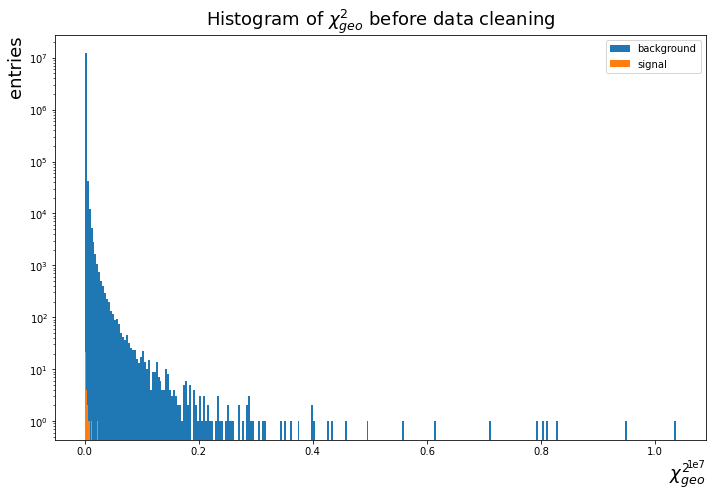

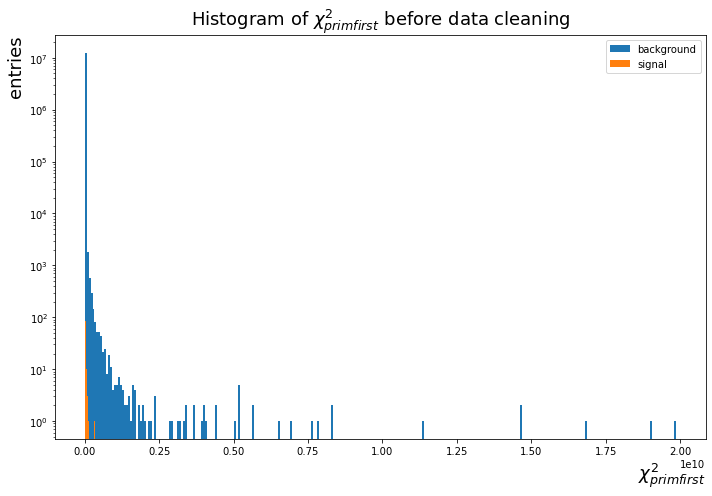

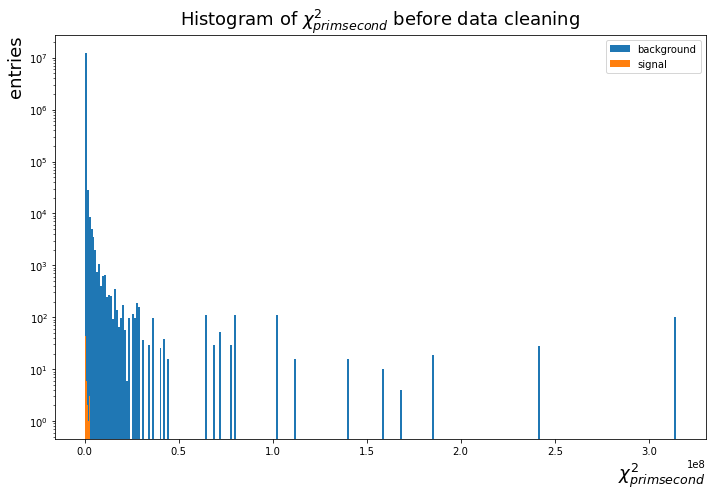

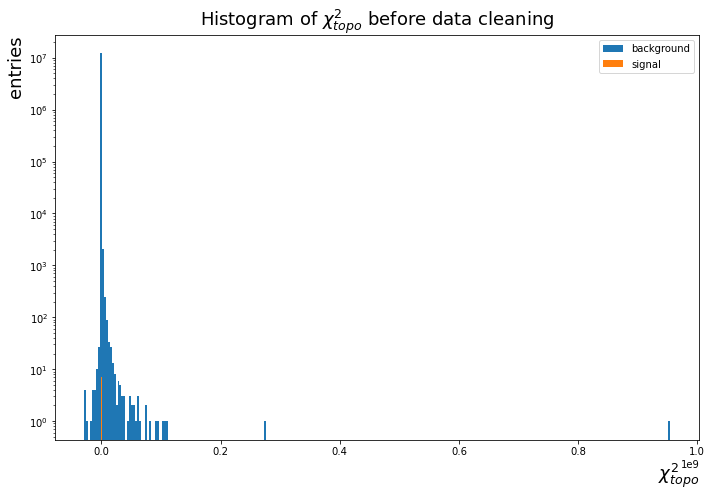

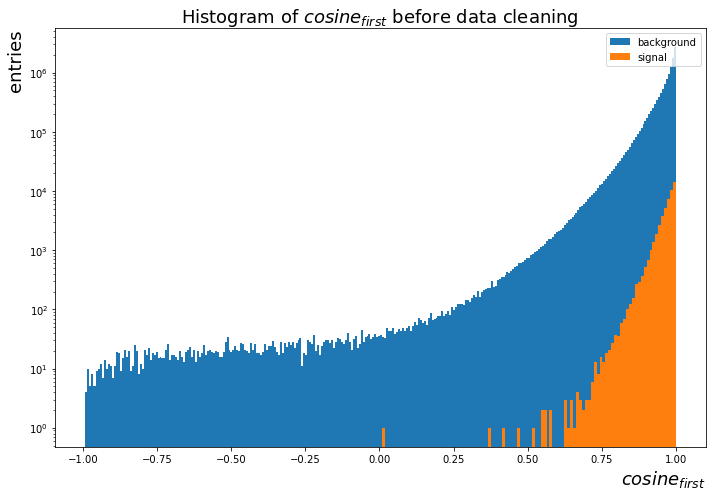

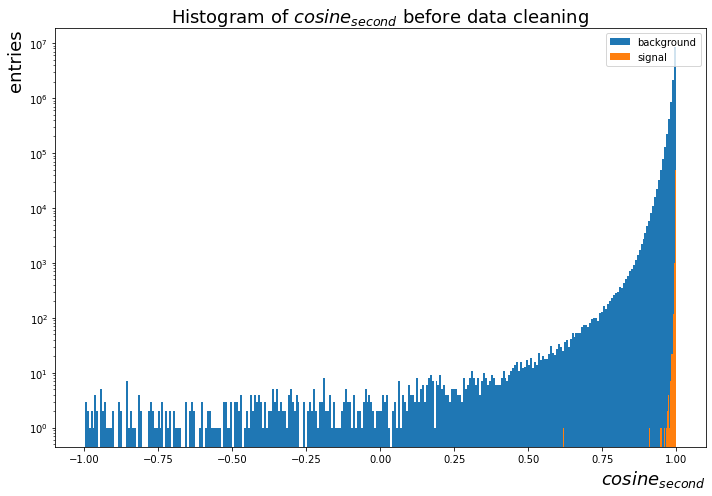

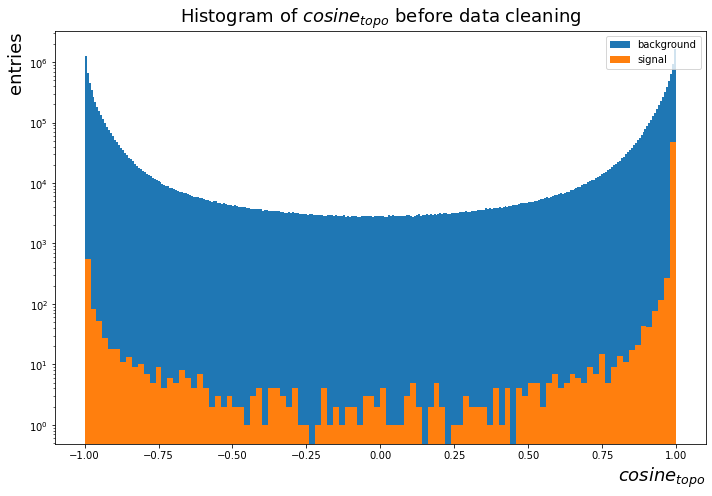

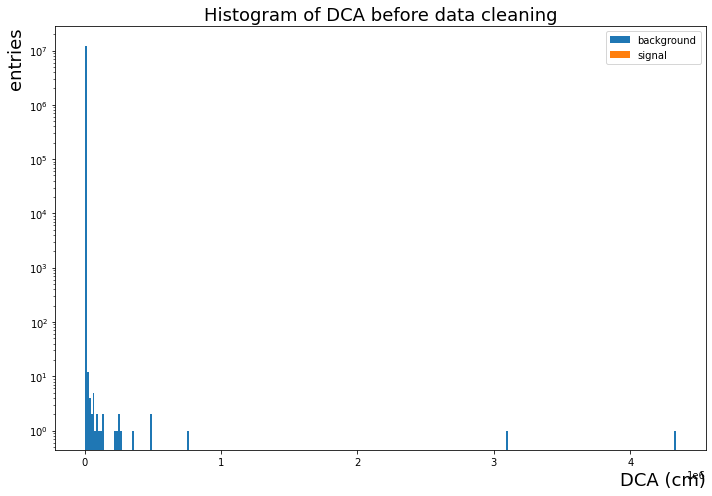

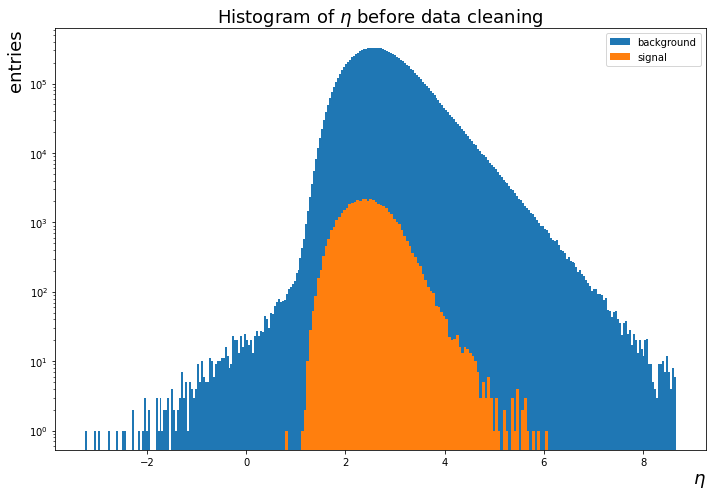

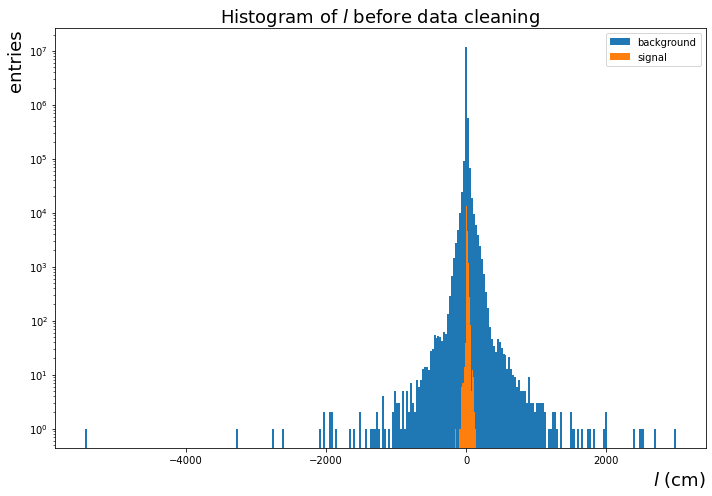

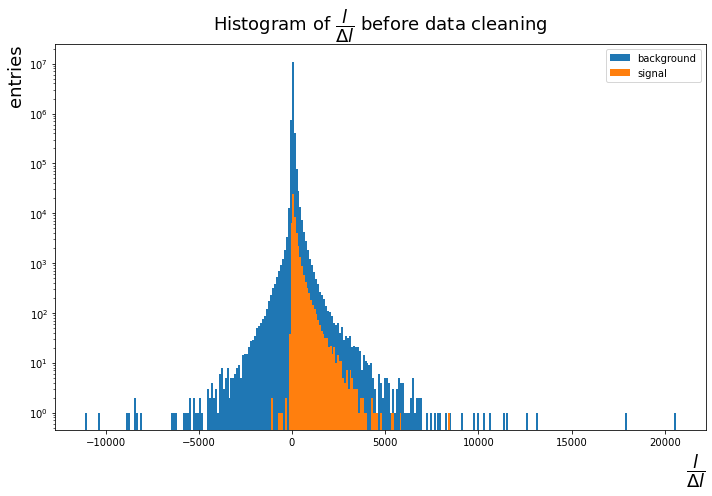

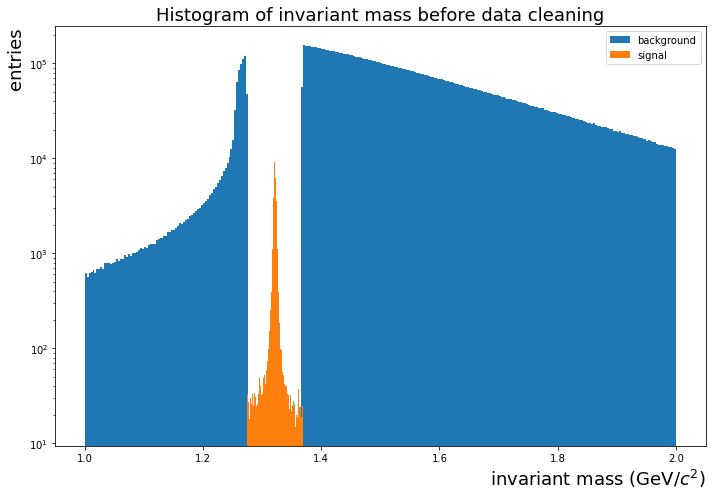

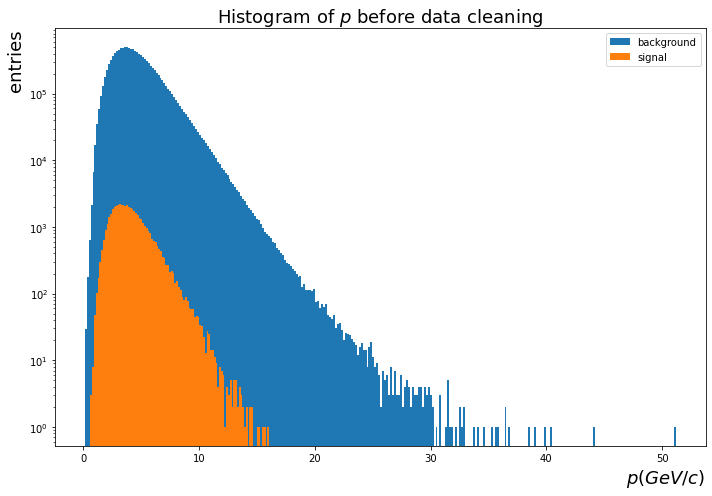

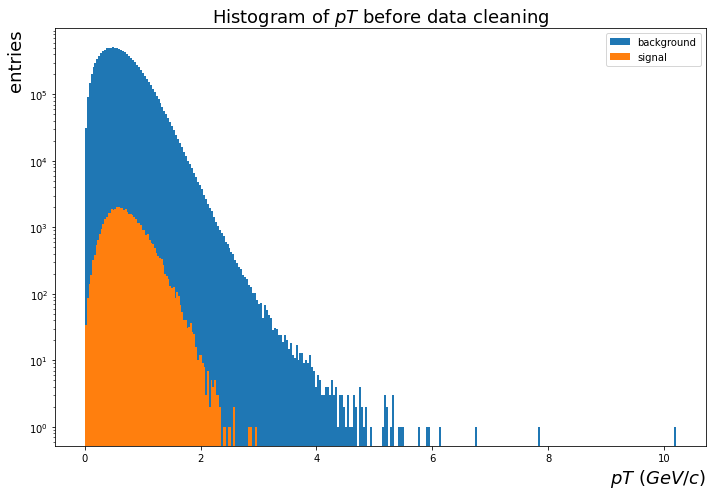

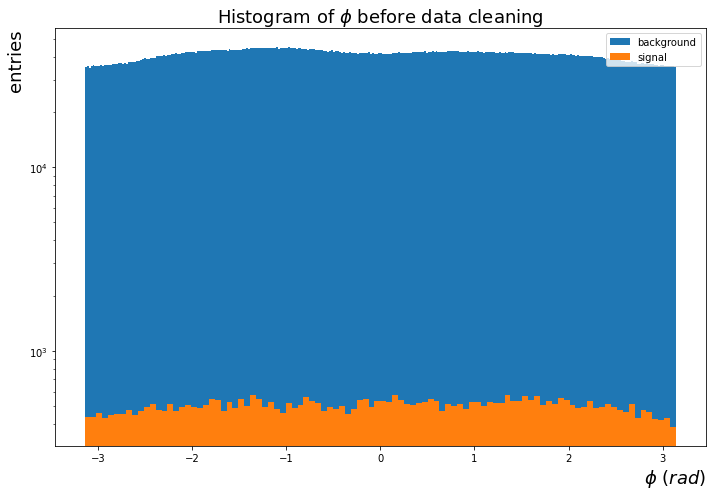

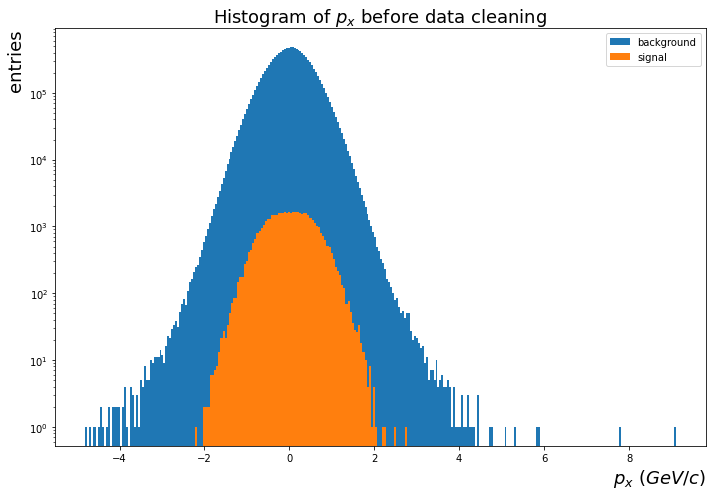

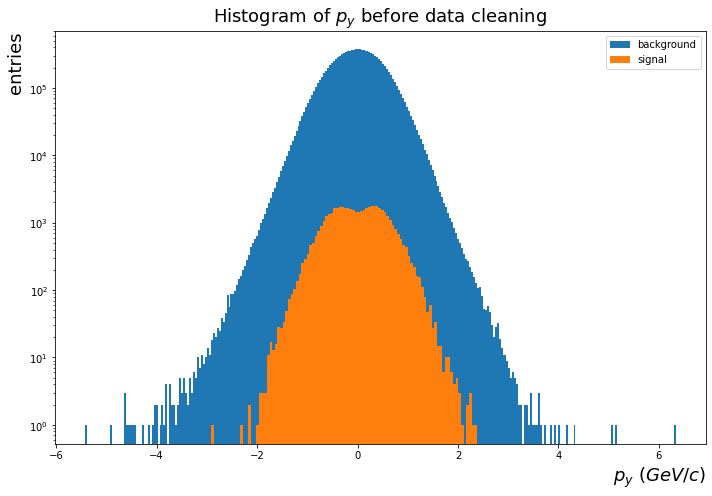

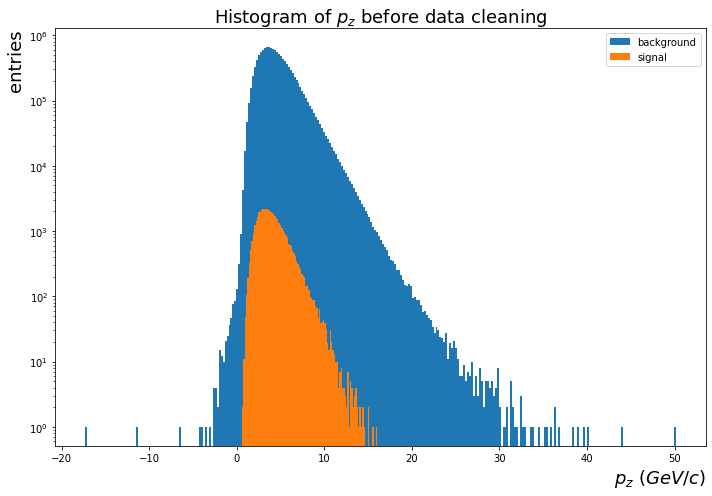

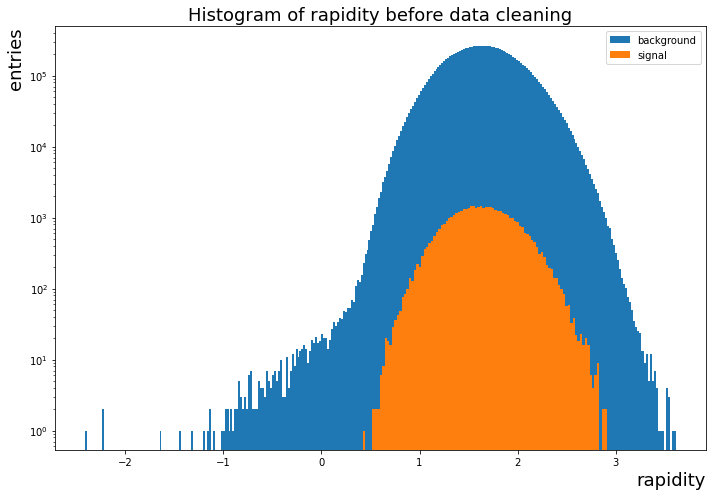

In [8]:
if not os.path.exists(directory+'img/histograms'):
    os.makedirs(directory+'img/histograms')
if not os.path.exists(directory+'img/histograms/before_cleaning'):
    os.makedirs(directory+'img/histograms/before_cleaning')
#we save all figures to pdf
pdf_beforeCleaning = PdfPages(directory+'img/histograms/histogramsBeforeCleaning.pdf') 
for i in sign.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = names[sign.columns.get_loc(i)]
    xName = xNames[sign.columns.get_loc(i)]
    plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
    plt.xlabel(xName, fontsize=18, loc='right')
    plt.ylabel("entries", fontsize=18, loc='top')
    plt.yscale('log')
    try:
        plt.hist(bckgr[i], bins =300, label='background')
        plt.hist(sign[i], bins=100, label='signal')
        plt.legend(loc='upper right')
        fig.tight_layout()
        fig.savefig(directory+"img/histograms/before_cleaning/"+ sign[i].name + ".png")
        fig.savefig(pdf_beforeCleaning,format='pdf')
    except ValueError:
        print('couldn\'t draw histogram (nan) for ' + name)
pdf_beforeCleaning.close()

755792

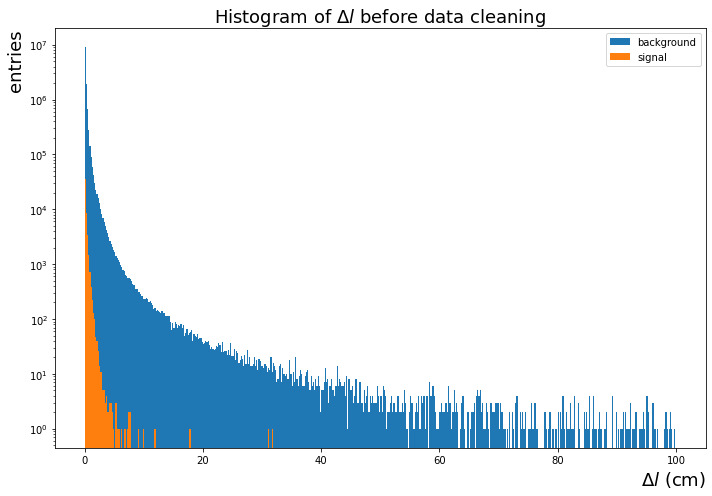

In [9]:
fig, ax = plt.subplots(figsize=(10,7))
fileName = 'DeltaL'
name = r'$\Delta l$'
xName = r'$\Delta l$ (cm)'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['l']/bckgr['loverdl'], bins =500, range=[0, 100], label='background')
    plt.hist(sign['l']/sign['loverdl'], bins=500, range=[0, 100], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"\\img\\histograms\\before_cleaning\\"+ fileName + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + fileName)
gc.collect()

# Zoomed histograms for cut variables

6614

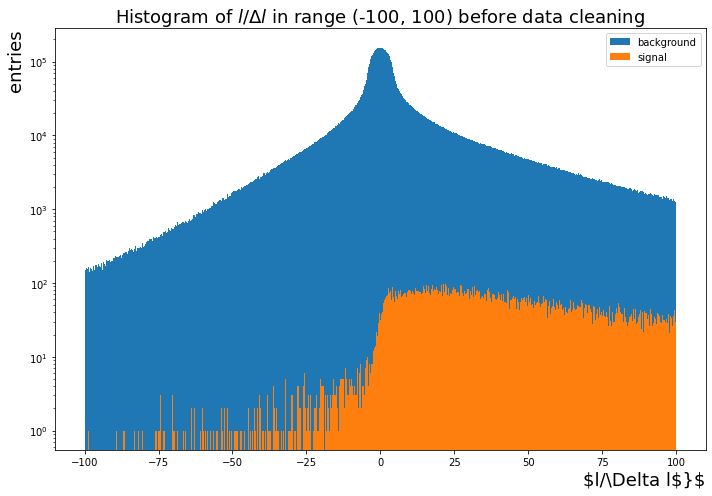

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$l/\Delta l$ in range (-100, 100)'
xName = r'$l/\Delta l$}$'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['loverdl'], bins =1000, range=[-100, 100], label='background')
    plt.hist(sign['loverdl'], bins=1000, range=[-100, 100], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    #fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

3862

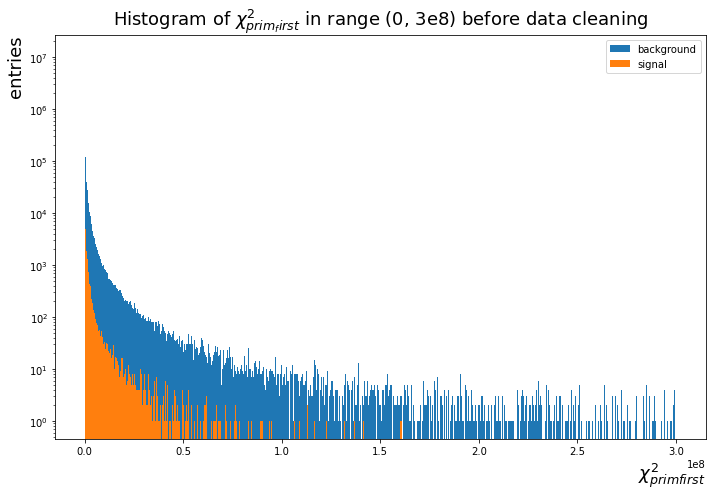

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\chi^{2}_{prim_first}$ in range (0, 3e8)'
xName = r'$\chi^{2}_{prim first}$'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['chi2primfirst'], bins =1000, range=[0, 300000000], label='background')
    plt.hist(sign['chi2primfirst'], bins=1000, range=[0, 300000000], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    #fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

3520

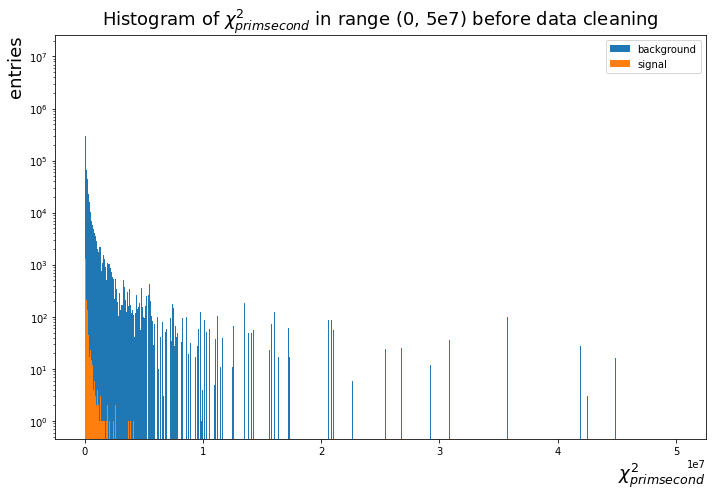

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\chi^{2}_{prim second}$ in range (0, 5e7)'
xName = r'$\chi^{2}_{prim second}$'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['chi2primsecond'], bins =1000, range=[0, 50000000], label='background')
    plt.hist(sign['chi2primsecond'], bins=1000, range=[0, 50000000], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    #fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

7400

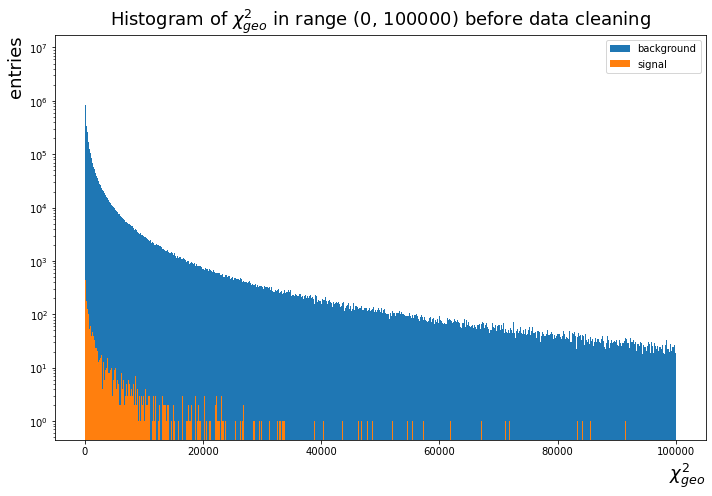

In [13]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\chi^{2}_{geo}$ in range (0, 100000)'
xName = r'$\chi^{2}_{geo}$'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['chi2geo'], bins =1000, range=[0, 100000], label='background')
    plt.hist(sign['chi2geo'], bins=1000, range=[0, 100000], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    #fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

7776

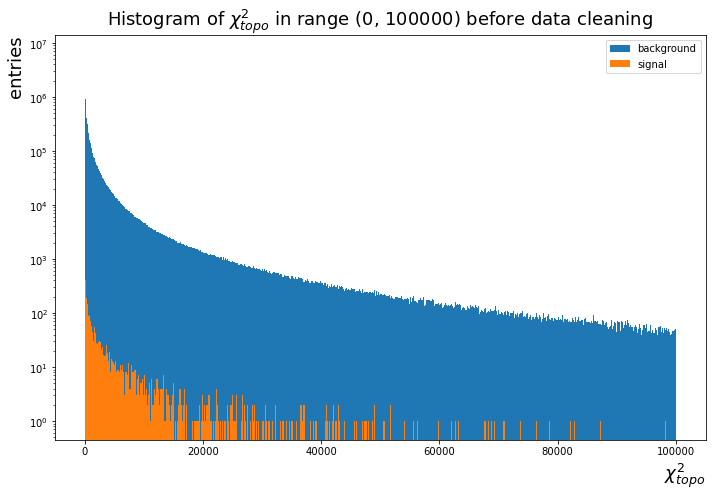

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
name = r'$\chi^{2}_{topo}$ in range (0, 100000)'
xName = r'$\chi^{2}_{topo}$'
plt.title('Histogram of ' + name + ' before data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr['chi2topo'], bins =1000, range=[0, 100000], label='background')
    plt.hist(sign['chi2topo'], bins=1000, range=[0, 100000], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    #fig.savefig(directory+"img/histograms/before_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

# DATA CLEANING

In [15]:
#CUTS USED FOR DATA CLEANING
#mass cuts for both bckgr and sign
lowerMassCut = 1.254 #threshold area (lambda mass + pion- mass)
upperMassCut = 1.6
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = -5
upperLCut = 80
#loverdl
lowerLdlCut = -25
upperLdlCut = 15000
#coordinate cuts -> I do not have them here!
absXCut = 50
absYCut = 50
lowerZCut = -1
upperZCut = 80
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 100000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 1e8
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 1e8
#pseudorapidity cuts
lowerEtaCut = 1.
upperEtaCut = 6.5

In [16]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #momentum
    size_mom =  len(df[['pz', 'p', 'pT']])
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    percentage_mom = ( size_mom - len(df[is_good_mom]) ) / size_mom
    print('with the momentum selection criteria we lose we loose ' + str(round(percentage_mom*100, 4)) + '% of entries')
    #coordinates
#    size_coord  =  len(df[['x', 'y', 'z']])
#    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
#    percentage_coord = ( size_coord - len(df[is_good_coord]) ) / size_coord
#    print('with the coordinates selection criteria we lose we loose ' + str(round(percentage_coord*100, 2)) + '% of entries')
    #eta
    size_eta =  len(df[['eta']])
    is_good_eta = (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)
    percentage_eta = ( size_eta - len(df[is_good_eta]) ) / size_eta
    print('with the pseudorapidity selection criteria we lose we loose ' + str(round(percentage_eta*100, 3)) + '% of entries')
    #DCA
    size_distance =  len(df[['distance']])
    is_good_distance = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) 
    percentage_distance = ( size_distance - len(df[is_good_distance]) ) / size_distance
    print('with the DCA selection criteria we lose we loose ' + str(round(percentage_distance*100, 3)) + '% of entries')
    #l and loverld
    size_l =  len(df[['l', 'loverdl']])
    is_good_l = (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    percentage_l = ( size_l - len(df[is_good_l]) ) / size_l
    print('with the l and loverdl selection criteria we lose we loose ' + str(round(percentage_l*100, 2)) + '% of entries')
    #chi2 geo and topo
    size_chi2geo_topo =  len(df[['chi2geo', 'chi2topo']])
    is_good_chi2geo_topo = (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) 
    percentage_chi2geo_topo = ( size_chi2geo_topo - len(df[is_good_chi2geo_topo]) ) / size_chi2geo_topo
    print('with the chi^2 geo and topo selection criteria we lose we loose ' + str(round(percentage_chi2geo_topo*100, 2)) + '% of entries')
    #chi^2 prim
    size_daughters =  len(df[['chi2primfirst', 'chi2primsecond']])
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimFirstCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimSecondCut)
    percentage_daughters = ( size_daughters - len(df[is_good_daughters]) ) / size_daughters
    print('with the chi^2 prim selection criteria we lose we loose ' + str(round(percentage_daughters*100, 2)) + '% of entries')
    #mass
    size_mass =  len(df[['mass']])
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)
    percentage_mass = ( size_mass - len(df[is_good_mass]) ) / size_mass
    print('with the mass selection criteria we lose we loose ' + str(round(percentage_mass*100, 4)) + '% of entries')

    is_good_df = (is_good_mom) & (is_good_eta) & (is_good_distance) & (is_good_l) & (is_good_chi2geo_topo) & (is_good_daughters) & (is_good_mass) 
       
    return df[is_good_df]

In [17]:
#we'll count how much data we loose
bckgrCount = len(bckgr)
signCount = len(sign)
#we return to normal names while cleaning data
print('for background: ')
background = clean_df(bckgr)
print('\nfor signal: ')
signal = clean_df(sign)
backgroundCount = len(background)
signalCount = len(signal)
#lets count how much data we lose
backgroundDifference = bckgrCount-backgroundCount
signalDifference = signCount-signalCount
percentageBg = backgroundDifference/bckgrCount*100
percentageSg = signalDifference/signCount*100
#finally
print('\nwe lost ' + str(backgroundDifference)+' background entries (' + str(round(percentageBg, 2)) + '%) and ' + str(signalDifference) + ' signal entries (' + str(round(percentageSg)) + '%)')
gc.collect()

for background: 
with the momentum selection criteria we lose we loose 0.019% of entries
with the pseudorapidity selection criteria we lose we loose 0.046% of entries
with the DCA selection criteria we lose we loose 0.05% of entries
with the l and loverdl selection criteria we lose we loose 7.23% of entries
with the chi^2 geo and topo selection criteria we lose we loose 0.6% of entries
with the chi^2 prim selection criteria we lose we loose 0.02% of entries
with the mass selection criteria we lose we loose 34.0623% of entries

for signal: 
with the momentum selection criteria we lose we loose 0.0% of entries
with the pseudorapidity selection criteria we lose we loose 0.002% of entries
with the DCA selection criteria we lose we loose 0.002% of entries
with the l and loverdl selection criteria we lose we loose 0.97% of entries
with the chi^2 geo and topo selection criteria we lose we loose 0.21% of entries
with the chi^2 prim selection criteria we lose we loose 0.05% of entries
with the 

1994

# Histograms after data cleaning

In [18]:
#cuts names to show on graphs after cuts
cutNames=[str(lowerChi2GeoCut)+' < $\chi^2_{geo}$ < '+str(upperChi2GeoCut), 
          str(lowerChi2PrimFirstCut)+' < $\chi^2_{prim first}$ < '+str(upperChi2PrimFirstCut),
          str(lowerChi2PrimSecondCut)+' < $\chi^2_{prim second}$ < '+str(upperChi2PrimSecondCut), 
          str(lowerChi2TopoCut)+' < $\chi^2_{topo}$ < '+str(upperChi2TopoCut),
          'no cuts',
          'no cuts',
          'no cuts',
          str(lowerDcaCut)+' < $DCA$ < '+str(upperDcaCut),
          str(lowerEtaCut)+' < $\eta$ < '+str(upperEtaCut),
          str(lowerLCut)+' < $l$ < '+str(upperLCut),
          str(lowerLdlCut)+' < $\dfrac{l}{\Delta l}$ < '+str(upperLdlCut),
          str(lowerMassCut)+' < invariant mass < '+str(upperMassCut),
          '$p$ < '+str(pUpperCut),
          '$pT$ < '+str(ptUpperCut),
          'no cuts',
          'no cuts',
          'no cuts',
          str(pzLowerCut)+' < $p_z$ ',
          'no cuts',
          '$|x|$ < '+str(absXCut),
          '$|y|$ < '+str(absYCut),
          str(lowerZCut)+' < $z$ < '+str(upperZCut),    
]

8646

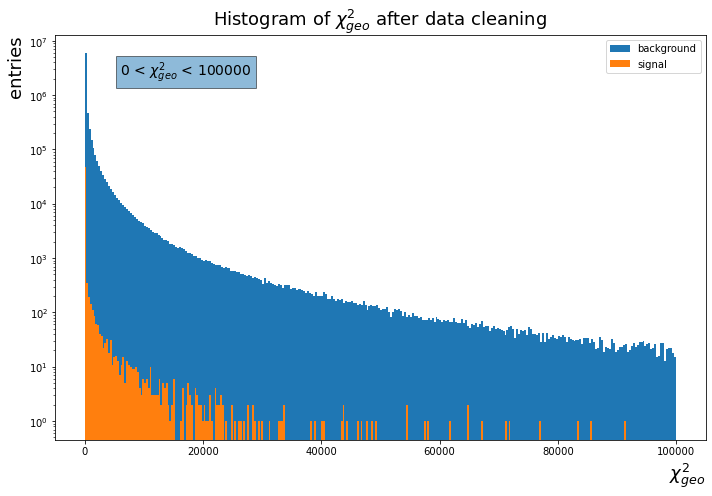

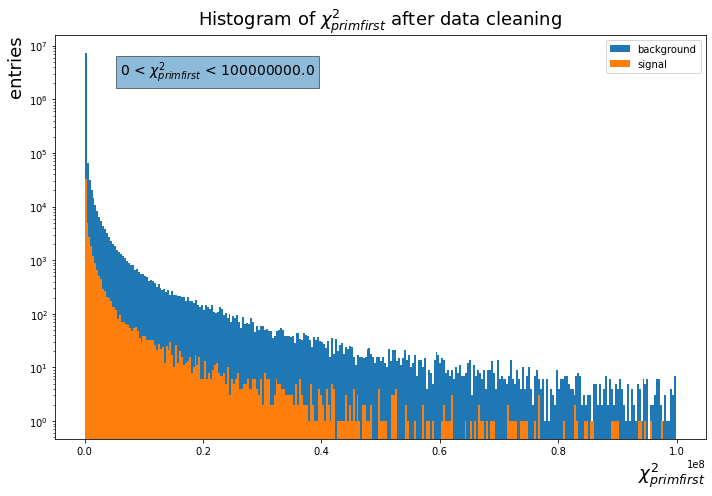

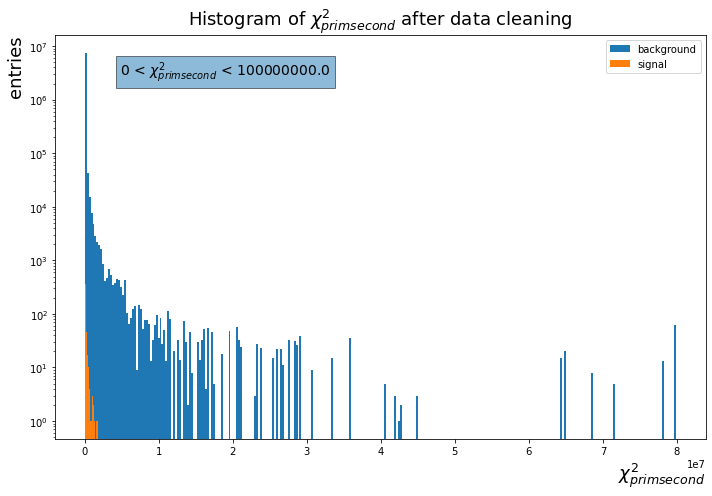

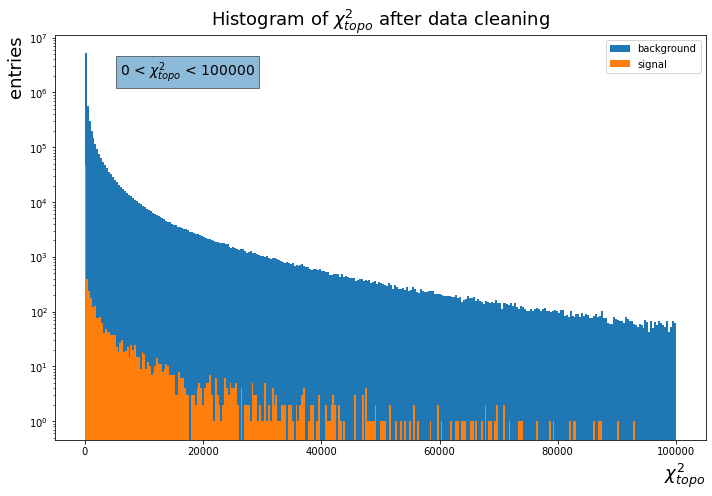

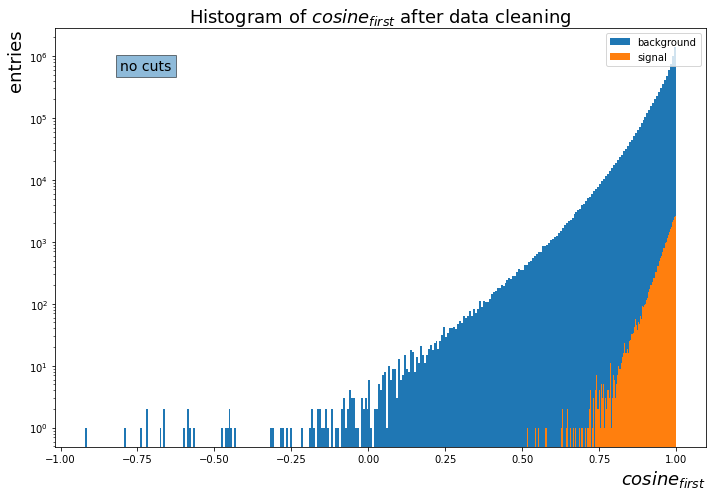

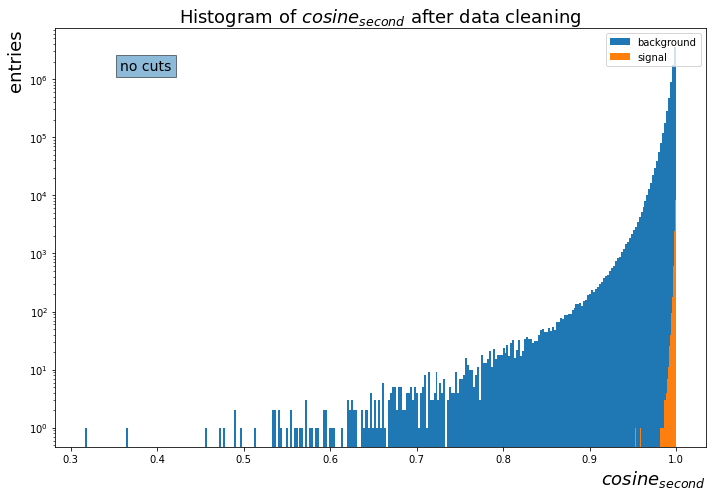

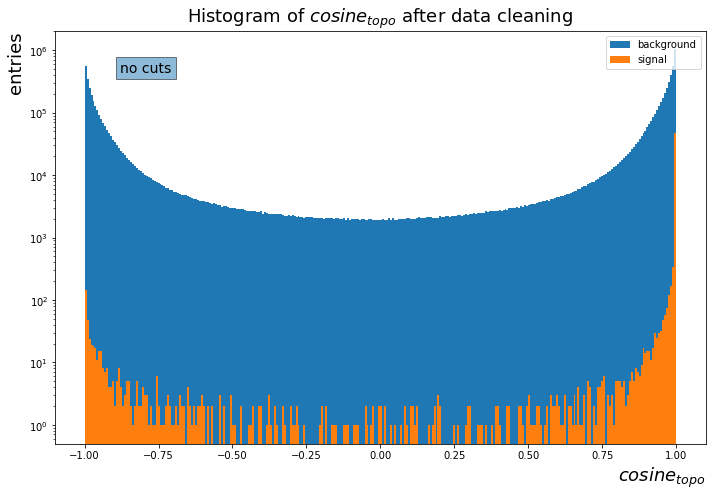

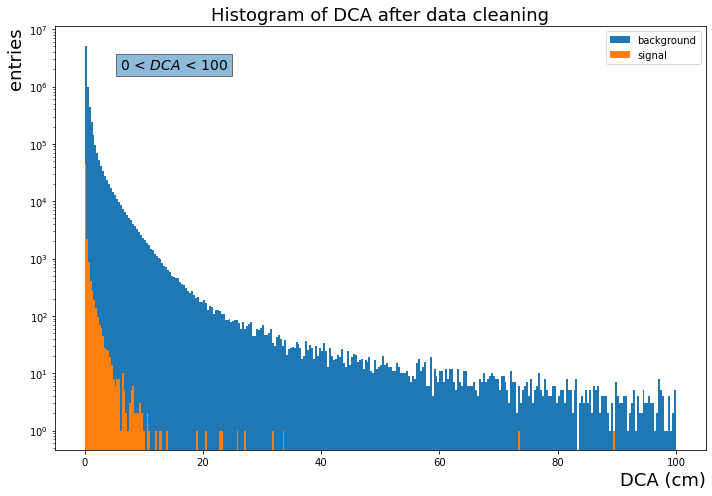

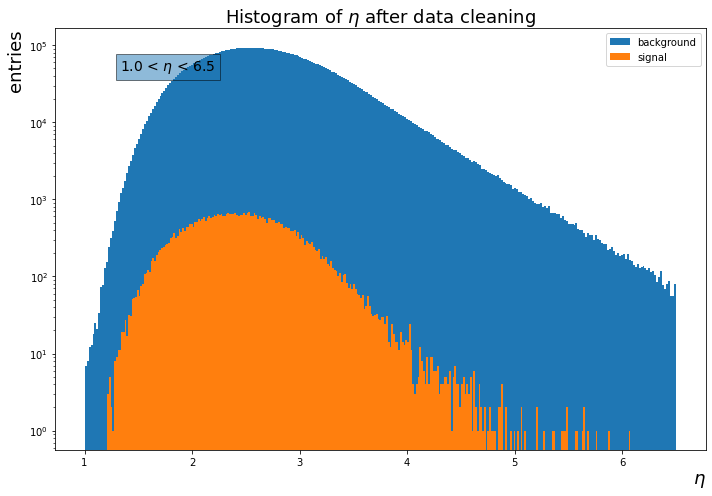

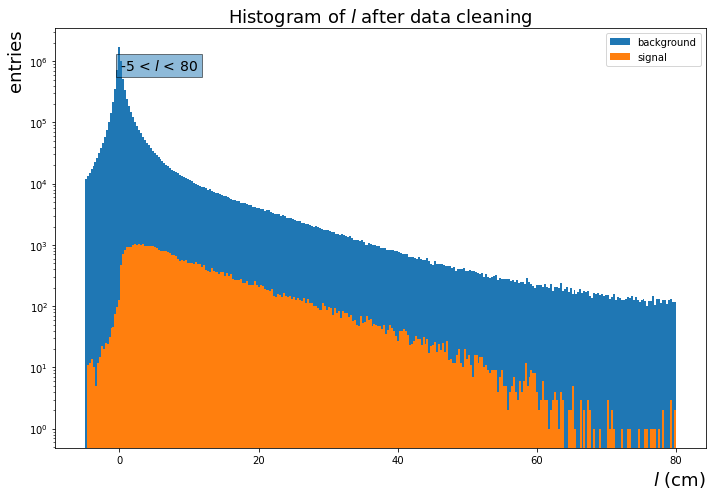

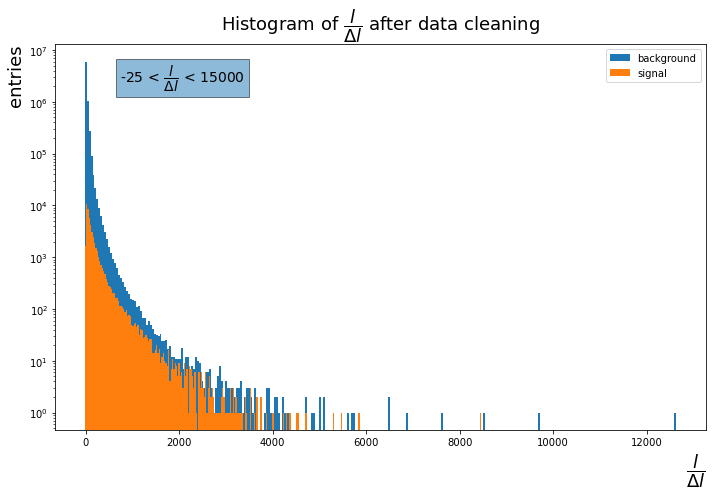

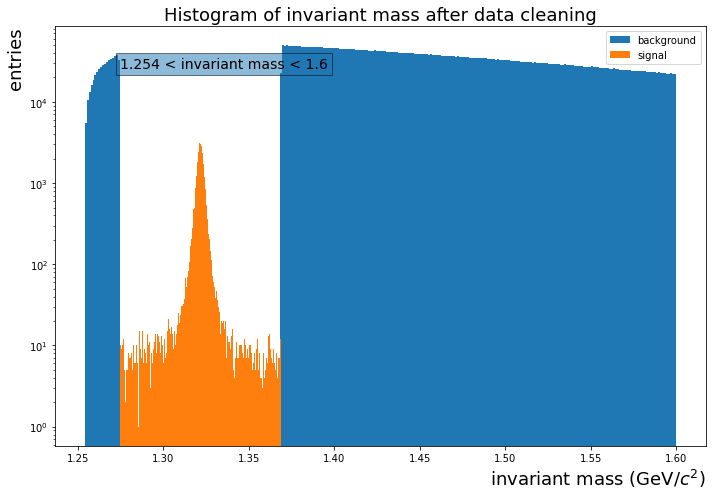

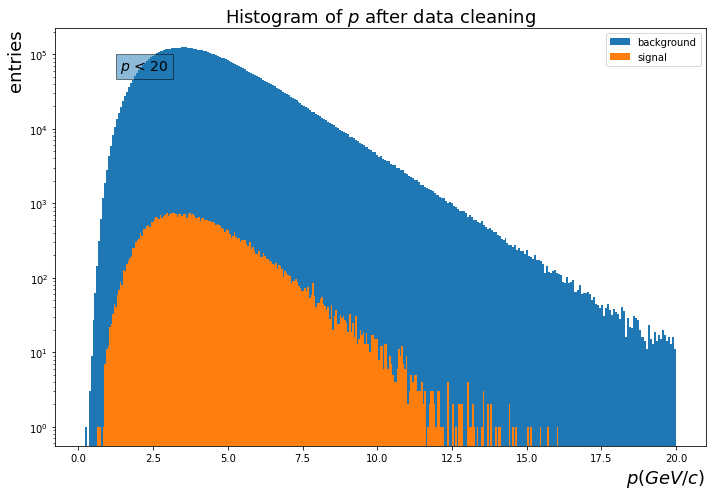

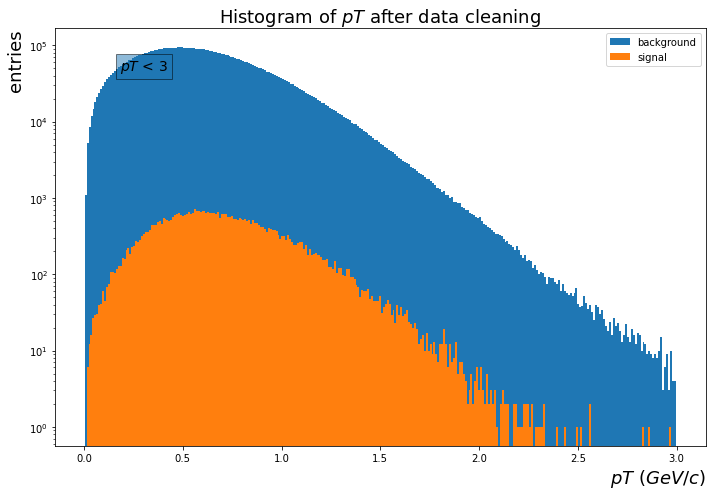

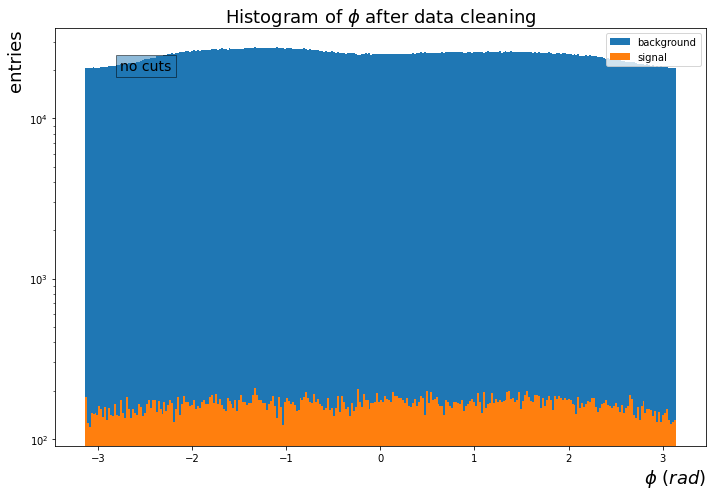

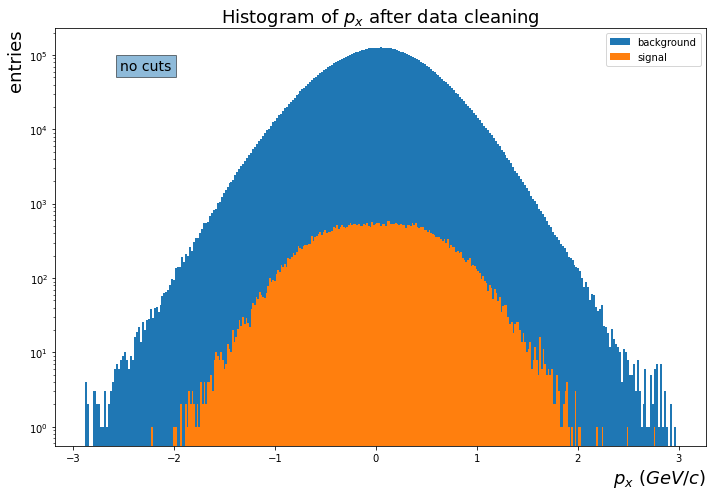

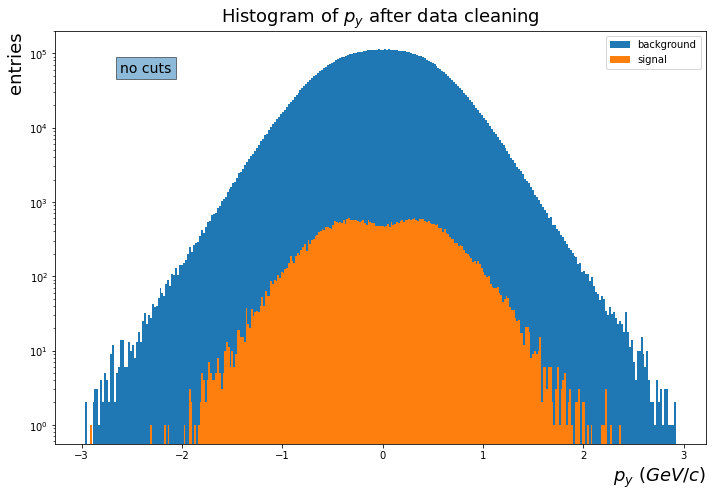

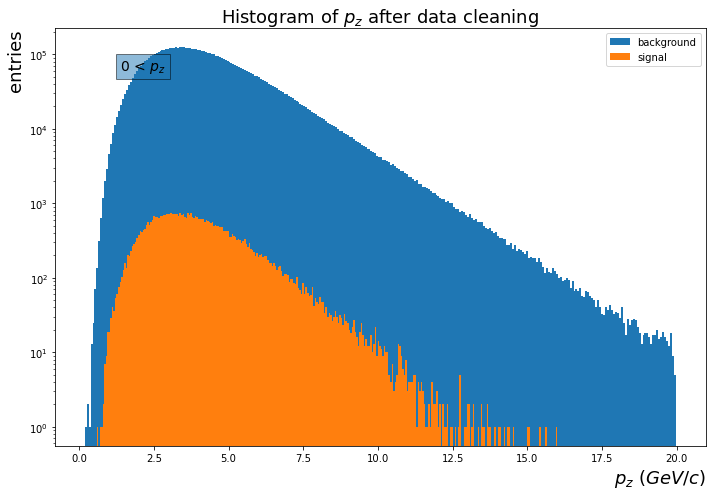

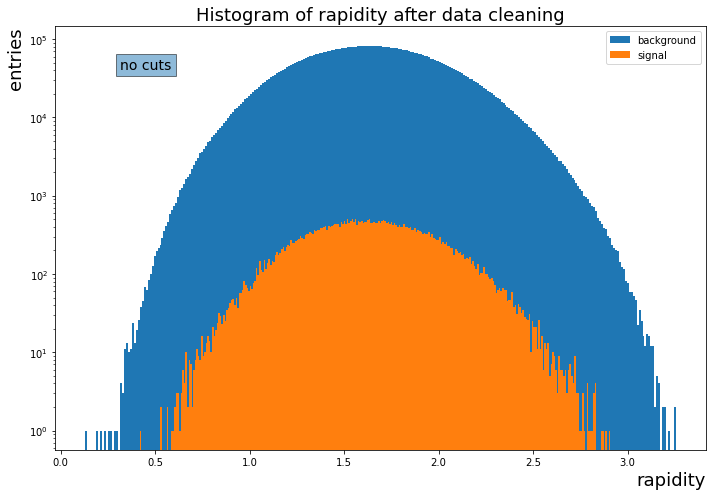

In [19]:
if not os.path.exists(directory+'img/histograms/after_cleaning'):
    os.makedirs(directory+'img/histograms/after_cleaning')
pdf_afterCleaning = PdfPages(directory+'img/histograms/histogramsAfterCleaning.pdf') 
for i in signal.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = names[signal.columns.get_loc(i)]
    xName = xNames[signal.columns.get_loc(i)]
    cutName = cutNames[signal.columns.get_loc(i)]
    plt.title('Histogram of ' + name + ' after data cleaning', fontsize=18)
    plt.xlabel(xName, fontsize=18, loc='right')
    plt.ylabel("entries", fontsize=18, loc='top')
    plt.yscale('log')
    ##########coordinates for box with cuts info
    plt.annotate(cutName, xy=(0.1, 0.9), xycoords='axes fraction',
        fontsize = 14, bbox = dict(alpha = 0.5))
    ###########
    try:
        plt.hist(background[i], bins =300, label='background')
        plt.hist(signal[i], bins=300, label='signal')
        plt.legend(loc='upper right')
        fig.tight_layout()
        fig.savefig(directory+"img/histograms/after_cleaning/"+ signal[i].name + ".png")
        plt.savefig(pdf_afterCleaning,format='pdf')
    except ValueError:
        print('couldn\'t draw histogram (nan) for ' + name)
pdf_afterCleaning.close()
gc.collect()

1050414

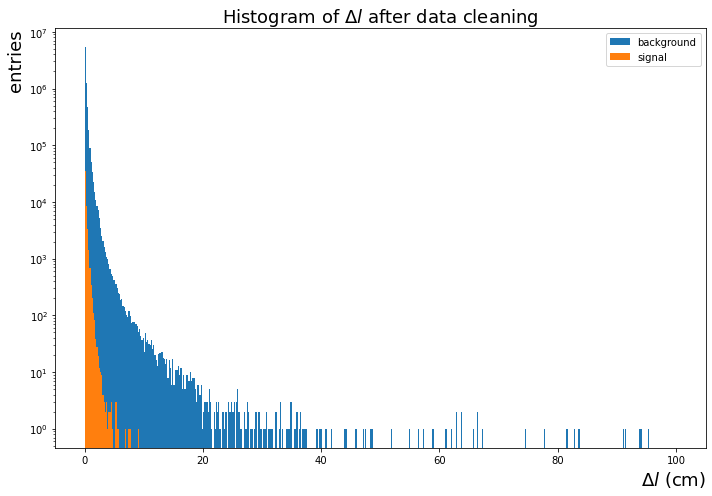

In [20]:
#histogram of delta l (division between l and loverdl)
fig, ax = plt.subplots(figsize=(10,7))
nameFile='DeltaL'
name = r'$\Delta l$'
xName = r'$\Delta l$ (cm)'
plt.title('Histogram of ' + name + ' after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(background['l']/background['loverdl'], bins=500, range=[0, 100], label='background')
    plt.hist(signal['l']/signal['loverdl'], bins=500, range=[0, 100], label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ nameFile + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

92031

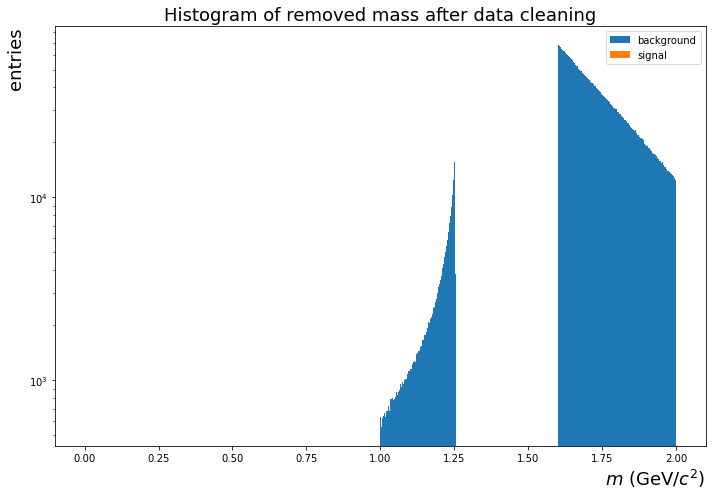

In [21]:
#difference between mass before and after cut
is_good_bckgr_mass = (bckgr['mass']>lowerMassCut) & (bckgr['mass']<upperMassCut)
is_good_sign_mass = (sign['mass']>lowerMassCut) & (sign['mass']<upperMassCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_mass'
xName = r'$m$ (GeV/$c^2$)'
plt.title('Histogram of removed mass after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mass]['mass'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mass]['mass'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

42971

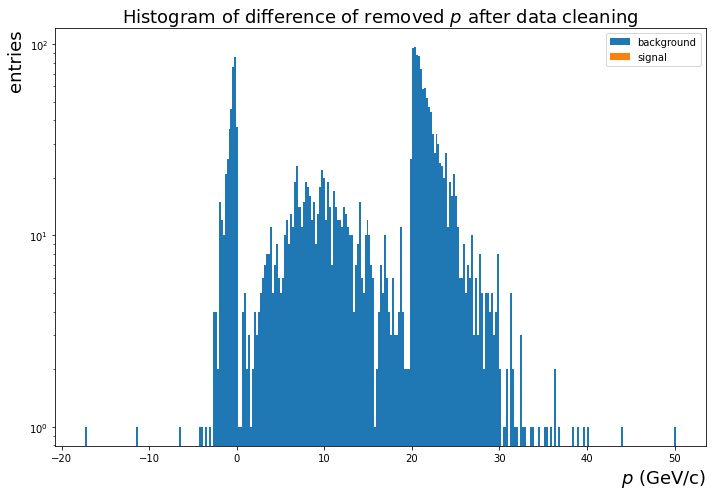

In [22]:
#difference between p before and after cut
is_good_bckgr_mom = (bckgr['pz'] > pzLowerCut) & (bckgr['p']<pUpperCut) & (bckgr['pT']<ptUpperCut)
is_good_sign_mom = (sign['pz'] > pzLowerCut) & (sign['p']<pUpperCut) & (sign['pT']<ptUpperCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_p'
xName = r'$p$ (GeV/c)'
plt.title('Histogram of difference of removed $p$ after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mom]['pz'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mom]['pz'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

42232

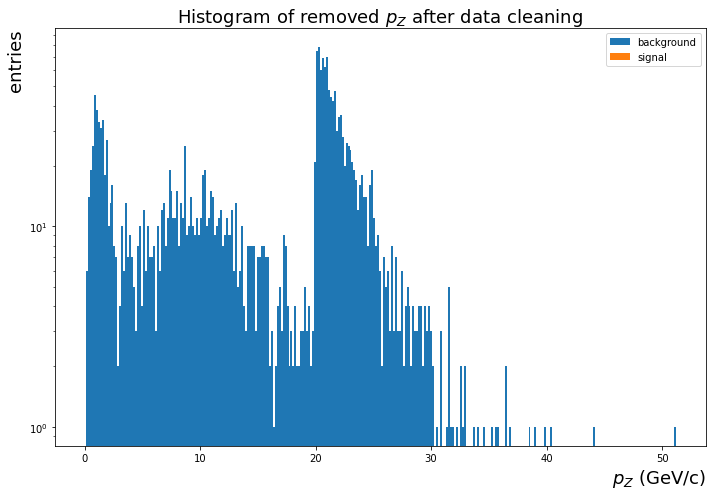

In [23]:
#difference between p before and after cut
is_good_bckgr_mom = (bckgr['pz'] > pzLowerCut) & (bckgr['p']<pUpperCut) & (bckgr['pT']<ptUpperCut)
is_good_sign_mom = (sign['pz'] > pzLowerCut) & (sign['p']<pUpperCut) & (sign['pT']<ptUpperCut)
fig, ax = plt.subplots(figsize=(10,7))
name = 'diff_pz'
xName = r'$p_Z$ (GeV/c)'
plt.title('Histogram of removed $p_Z$ after data cleaning', fontsize=18)
plt.xlabel(xName, fontsize=18, loc='right')
plt.ylabel("entries", fontsize=18, loc='top')
plt.yscale('log')
try:
    plt.hist(bckgr[~is_good_bckgr_mom]['p'], bins =300, label='background')
    plt.hist(sign[~is_good_sign_mom]['p'], bins=100, label='signal')
    plt.legend(loc='upper right')
    fig.tight_layout()
    fig.savefig(directory+"img/histograms/after_cleaning/"+ name + ".png")
except ValueError:
    print('couldn\'t draw histogram (nan) for ' + name)
gc.collect()

# Correlation
We find the correlation of all variables with signal and background candidates. We use the pearson correlation coefficient (linear correlation) for our analysis. It is defined as$$
\rho = \frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
$$Here, COV(X,Y) is the covariance of the variable X and Y, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of the variables. Pearson co-efficient is useful for linear correlation but it fails to take into account outliers and non-linear correlation. $\rho \&gt; 0$ means postive while the opposite means negative correlation between two variables.

This correlation function comes in built in the pandas library so we are using it. This function can also find other non-linear correlation coefficients like kendall and spearman.

In [24]:
variables_to_draw = ['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity']

In [25]:
if not os.path.exists(directory+'img/correlations'):
    os.makedirs(directory+'img/correlations')
def correlation_graph(df, variables, title):
    # The variables pid, isfrompv and issignal are not that much varying so we remove them
    new_df = df[variables]
    # Using the pandas correlation function corr we find the correlation
    df_correlation_all = new_df.corr(method='pearson')
    
    #The cosmetics of the graph
    fig, ax = plt.subplots(figsize=(20,15))  #figure size
    cmap = sn.diverging_palette(240, 10, as_cmap=True, n=200) #color map
    cax = sn.heatmap(df_correlation_all, annot=True,cbar_kws={"shrink": .5},  cmap=cmap,  vmin=-1, vmax=1, 
                 center=0)
    ax.set_xticks(np.arange(0, len(df_correlation_all.columns), step=1))
    ax.set_xticklabels(df_correlation_all.columns, fontsize=15, rotation =70)
    ax.set_yticklabels(df_correlation_all.columns, fontsize=15)
    ax.set_title(title, fontsize = 20)
    fig.tight_layout()
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf')
    fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png')

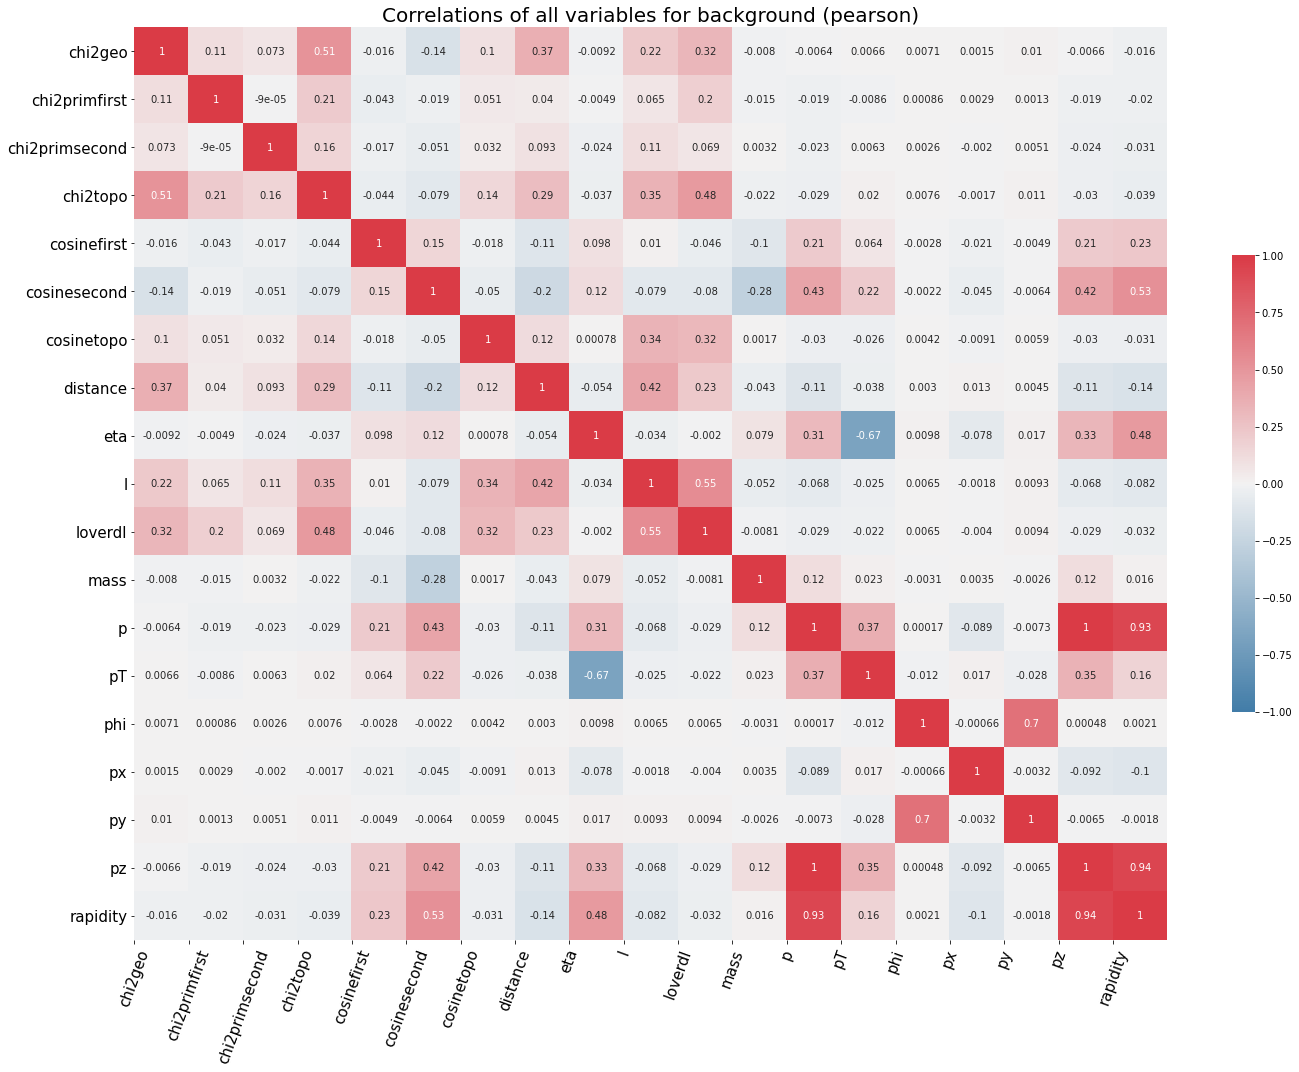

In [26]:
#correlation graph for background
correlation_graph(background, variables_to_draw, 'Correlations of all variables for background (pearson)')

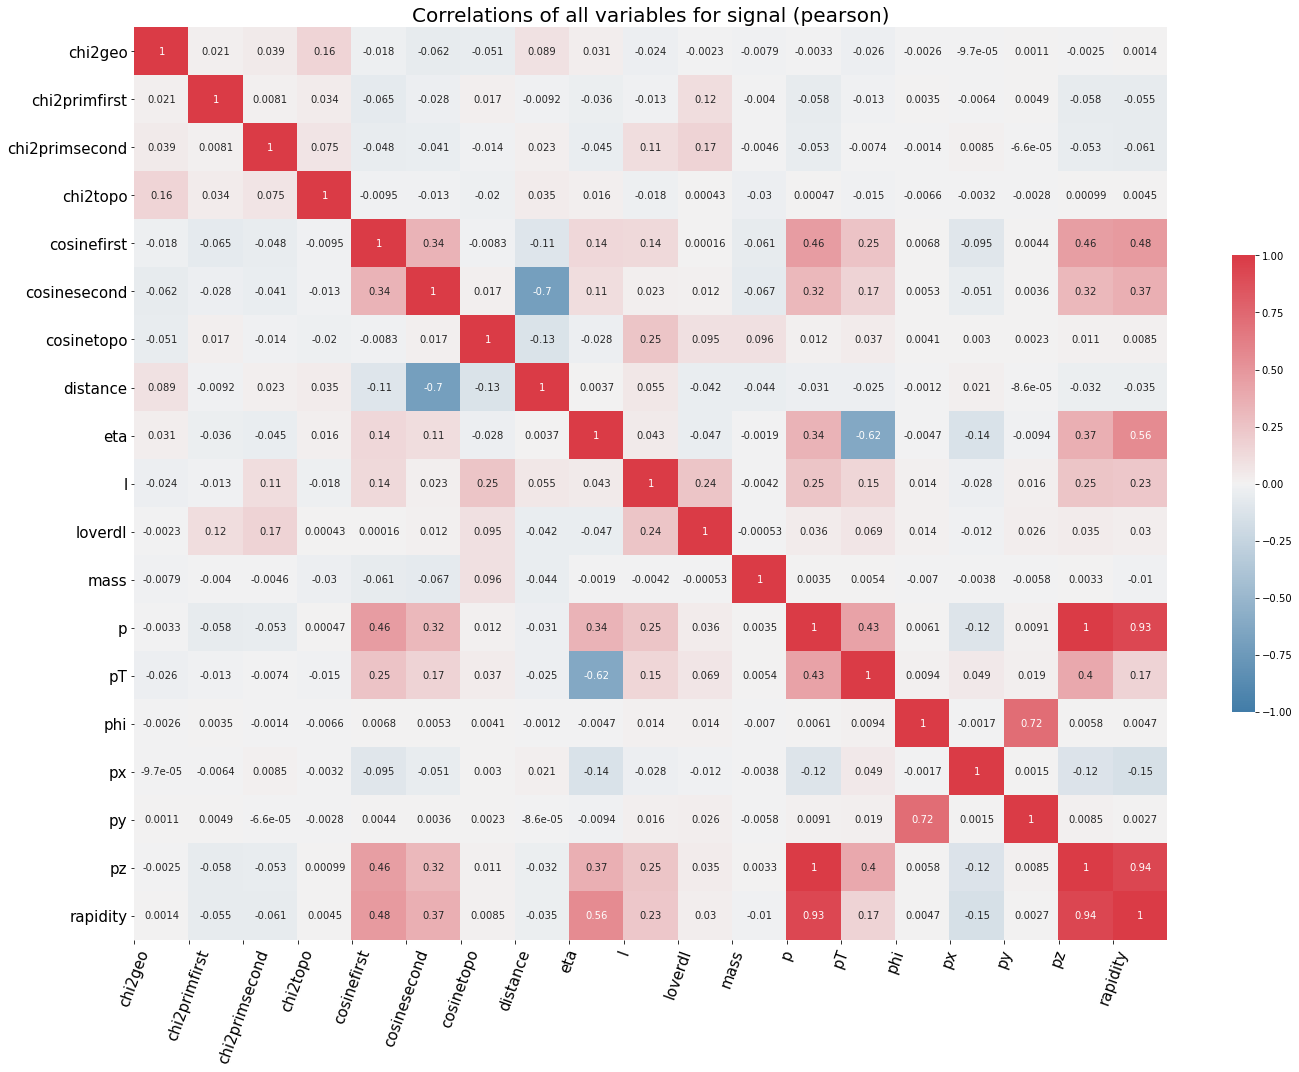

In [27]:
#correlation graph for signal
correlation_graph(sign, variables_to_draw, 'Correlations of all variables for signal (pearson)')

The correlation graph of the background variables shows that: cosinefirst, cosinesecond, $p_T$, $p_z$, and $p$ is correlated with mass. To check whether it is a real correlation or a statistical fluctuation we make our own correlation function.

# Correlations by formula
The following function calculates the correlation along with the standard error of the mean (SEM) of the input variable with all the other variables. The standard error of the mean is defined as $ SEM = \frac{\sigma}{\sqrt{n}}$. Here $\sigma$ is the standard deviation of a variable. It will put error bars on each bin.

The function accepts 3 variables, a data frame object in the first input, a list of strings to be correlated with the third input (a string).

In [28]:
def calculate_correlation(df, vars_to_corr, target_var) :

    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []

    for j in vars_to_corr :
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        if (sigma) and (sigma_j) != 0:
            cov = ((df[j] - mean_j) * (df[target_var] - mean)).mean() / (sigma*sigma_j)
            correlation.append(cov)
            error.append(sem(cov))
        else:
            print(str(vars_to_corr) + 'can\'t be calculated, sigma: ' + str(sigma) +' , sigma_j: ' +str(sigma_j))

    return correlation, error

In [29]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal, corr_signal_errors = calculate_correlation(signal, list(signal), 'mass')
# For background
corr_bg, corr_bg_errors = calculate_correlation(background, list(background), 'mass')

D:\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


D:\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-30-b06cd594b296>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


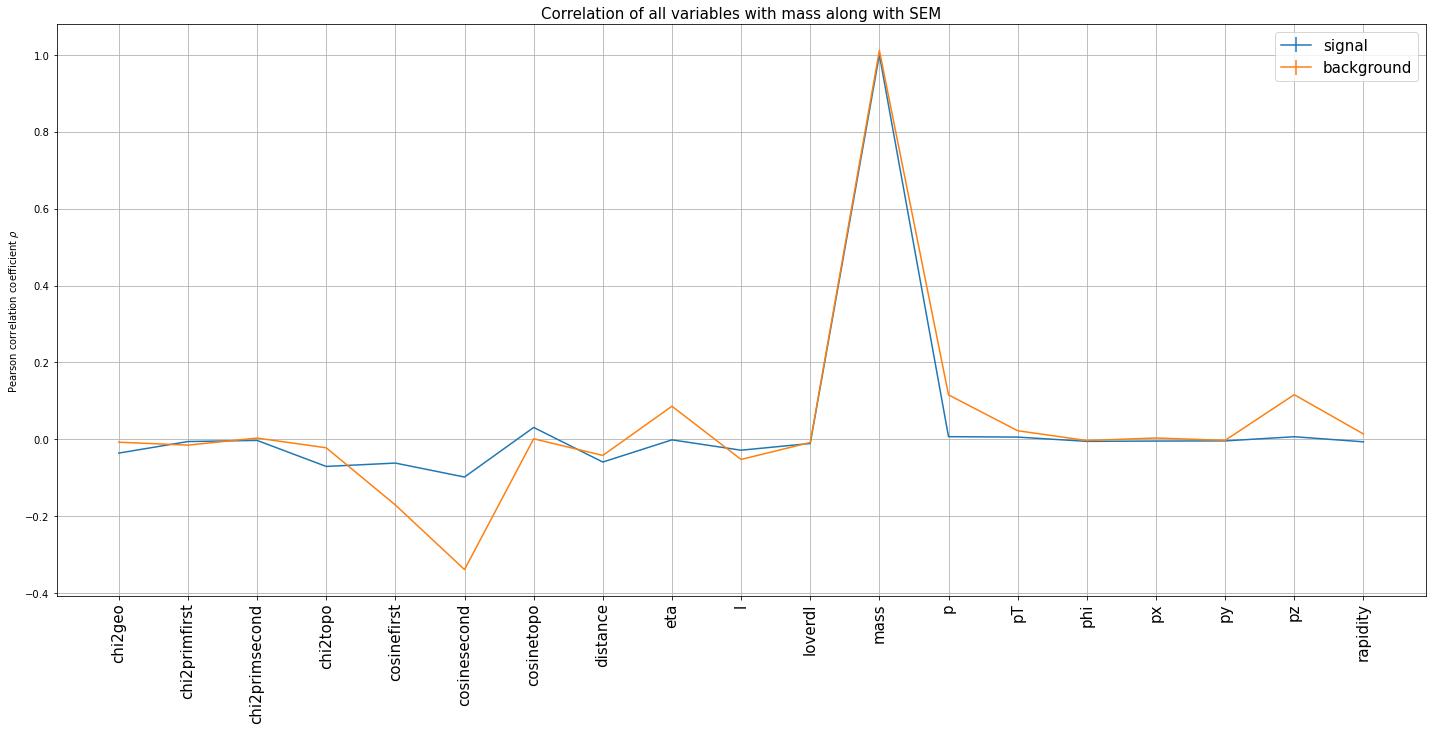

In [30]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal, yerr=corr_signal_errors, fmt='')
plt.errorbar(list(background), corr_bg, yerr=corr_bg_errors, fmt='')
ax.grid(zorder=0)
ax.set_ylabel('Pearson correlation coefficient $\\rho$')
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
plt.tight_layout()
title = 'Correlation of all variables with mass along with SEM'
plt.title(title, fontsize = 15)
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png', bbox_inches='tight')
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf', bbox_inches='tight')

# Mean based correlations

In [31]:
#mean based correlation
def calculate_correlation1(df, vars_to_corr, target_var) :

    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []

    for j in vars_to_corr :
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        if (sigma) and (sigma_j) != 0:
            cov = ((df[j] - mean_j) * (df[target_var] - mean)).mean() / (mean*mean_j)
            correlation.append(cov)
            error.append(sem(cov))
        else:
            print(str(vars_to_corr) + 'can\'t be calculated, sigma: ' + str(sigma) +' , sigma_j: ' +str(sigma_j))

    return correlation, error

In [32]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal1, corr_signal_errors1 = calculate_correlation1(signal, list(signal), 'mass')
# For background
corr_bg1, corr_bg_errors1 = calculate_correlation1(background, list(background), 'mass')

D:\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


D:\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-33-df199c6898cc>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


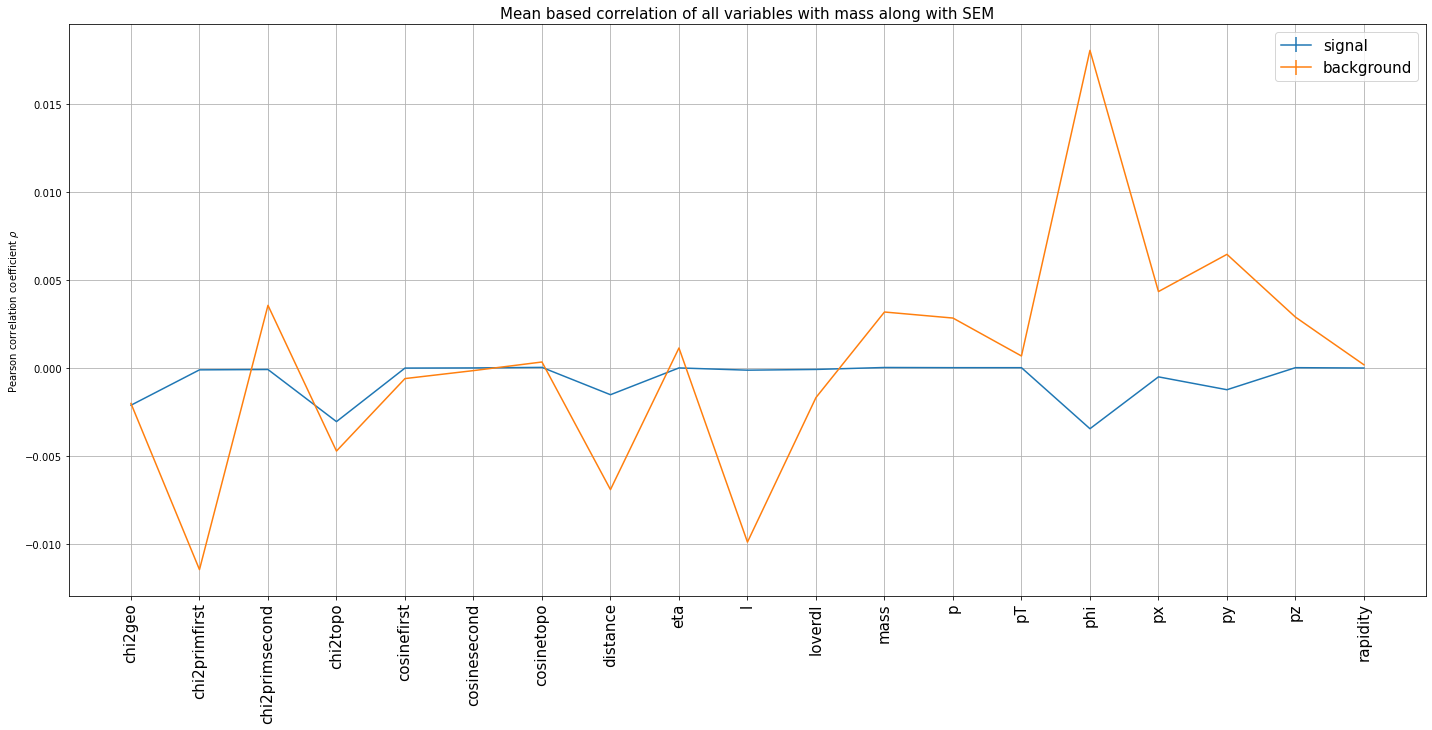

In [33]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal1, yerr=corr_signal_errors1, fmt='')
plt.errorbar(list(background), corr_bg1, yerr=corr_bg_errors1, fmt='')
ax.grid(zorder=0)
ax.set_ylabel('Pearson correlation coefficient $\\rho$')
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
plt.tight_layout()
title = 'Mean based correlation of all variables with mass along with SEM'
plt.title(title, fontsize = 15)
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.png', bbox_inches='tight')
fig.savefig(directory+'img/correlations/'+title.replace(' ', '_')+'.pdf', bbox_inches='tight')